## World Happiness Report (2017 - 2019)
### The Fundamentals of EDA and Data Visualization
Magnus Skonberg | April 12th 2023

### Project Intro

The purpose of this project is to generate a "pro level", audience-friendly explanatory data visualization using Matplotlib's built-in styles and information design principles.

We'll use [World Happiness Report data](https://www.kaggle.com/datasets/unsdsn/world-happiness?resource=download&select=2019.csv) from 2017-2019. The World Happiness Report was created to survey the state of global happiness. It ranks 155 countries by their perceived happiness levels and was intended to raise awareness on the differences between nations as well as the factors at play within a nation's bounds.

We'll explore the fundamentals of EDA and creating nice, crisp visualization while attempting to answer the questions of:
1. What countries are trending up vs. trending down?
2. What factor (if any) is most correlated with a country's world happiness score?

Let's begin!

### Load Data

To start we read in our data:

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

# Read in the data
data_2017 = pd.read_csv("2017.csv")
data_2018 = pd.read_csv("2018.csv")
data_2019 = pd.read_csv("2019.csv")

# Add Year Column
data_2017['Year'] = 2017
data_2018['Year'] = 2018
data_2019['Year'] = 2019

# Make column names consistent
data_2017 = data_2017.rename(columns={"Happiness.Rank":"Rank", "Happiness.Score":"Score", "Economy..GDP.per.Capita.":"Economy", "Family":"Social", "Health..Life.Expectancy.":"Health", "Trust..Government.Corruption.":"Corruption"})
data_2018 = data_2018.rename(columns={"Overall rank":"Rank", "Country or region": "Country", "GDP per capita":"Economy", "Social support":"Social", "Healthy life expectancy":"Health", "Freedom to make life choices":"Freedom", "Perceptions of corruption":"Corruption"})
data_2019 = data_2019.rename(columns={"Overall rank":"Rank", "Country or region": "Country", "GDP per capita":"Economy", "Social support":"Social", "Healthy life expectancy":"Health", "Freedom to make life choices":"Freedom", "Perceptions of corruption":"Corruption"})

# Join the datasets
all_data = pd.concat([data_2017, data_2018, data_2019])

# Drop inessential columns
all_data = all_data.drop(['Whisker.high','Whisker.low','Dystopia.Residual'], axis=1)

# Print data
all_data


,Country,Rank,Score,Economy,Social,Health,Freedom,Generosity,Corruption,Year
0,Norway,1,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2017
1,Denmark,2,7.522,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2017
2,Iceland,3,7.504,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2017
3,Switzerland,4,7.494,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2017
4,Finland,5,7.469,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2017
...,...,...,...,...,...,...,...,...,...,...
151,Rwanda,152,3.334,0.359000,0.711000,0.614000,0.555000,0.217000,0.411000,2019
152,Tanzania,153,3.231,0.476000,0.885000,0.499000,0.417000,0.276000,0.147000,2019
153,Afghanistan,154,3.203,0.350000,0.517000,0.361000,0.000000,0.158000,0.025000,2019
154,Central African Republic,155,3.083,0.026000,0.000000,0.105000,0.225000,0.235000,0.035000,2019


Upon reading in our data, we add a `Year` column (to differentiate between source sets), rename columns to ensure consistent column naming, join datasets, drop irrelevant columns, and produce the resulting set (above).

## High Level, Intro EDA

With our data loaded in, first we'll get an idea of the shape of our dataset and summary statistics:

In [2]:
# shape
all_data.shape

# summary stats
all_data.describe()

,Rank,Score,Economy,Social,Health,Freedom,Generosity,Corruption,Year
count,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,466.000000,467.000000
mean,78.334047,5.379064,0.926981,1.203681,0.624800,0.418642,0.204154,0.115231,2018.002141
std,44.985594,1.119092,0.405078,0.295919,0.252756,0.154046,0.114708,0.097554,0.816932
min,1.000000,2.693000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000
25%,39.500000,4.511500,0.628203,1.051500,0.454714,0.313000,0.120000,0.052000,2017.000000
50%,78.000000,5.339000,0.986000,1.258190,0.657000,0.443323,0.190134,0.086362,2018.000000
75%,117.000000,6.170500,1.245000,1.440726,0.817500,0.535500,0.262500,0.143750,2019.000000
max,156.000000,7.769000,2.096000,1.644000,1.141000,0.724000,0.838075,0.464308,2019.000000


*What can we gather from above?*

* Our dataset is 467 rows x 10 columns
* 6 columns are factors (ie. Economy), 2 provide indication regarding a country's ranking (Score and Rank), 1 is an identifier (Country), 1 is an index
* the simple of addition of difference max values (ie. Economy + Social + Health ...) does NOT equal the max. score. Thus the relationship / equation is non-linear and our exploration of which factor is most important appears to be valid.

## Missing values

We explore the presence of missing values within our dataset:

<AxesSubplot:>

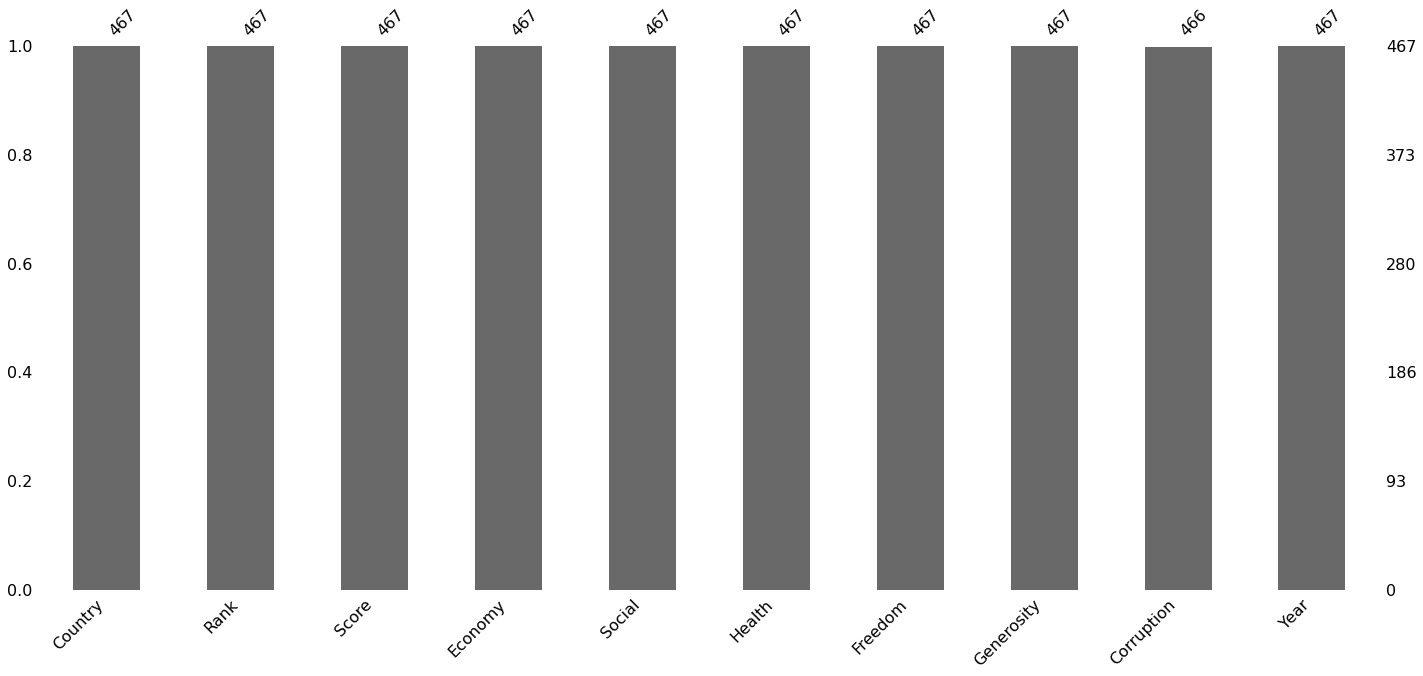

In [3]:
# Missing value exploration

msno.bar(all_data)


We utilize the `missingno` library to visualize missing values. Per the above output, and as expected, there are NO missing values and so we do not have to impute, drop, or otherwise handle missing values.

## Outliers

We explore outliers within our dataset:

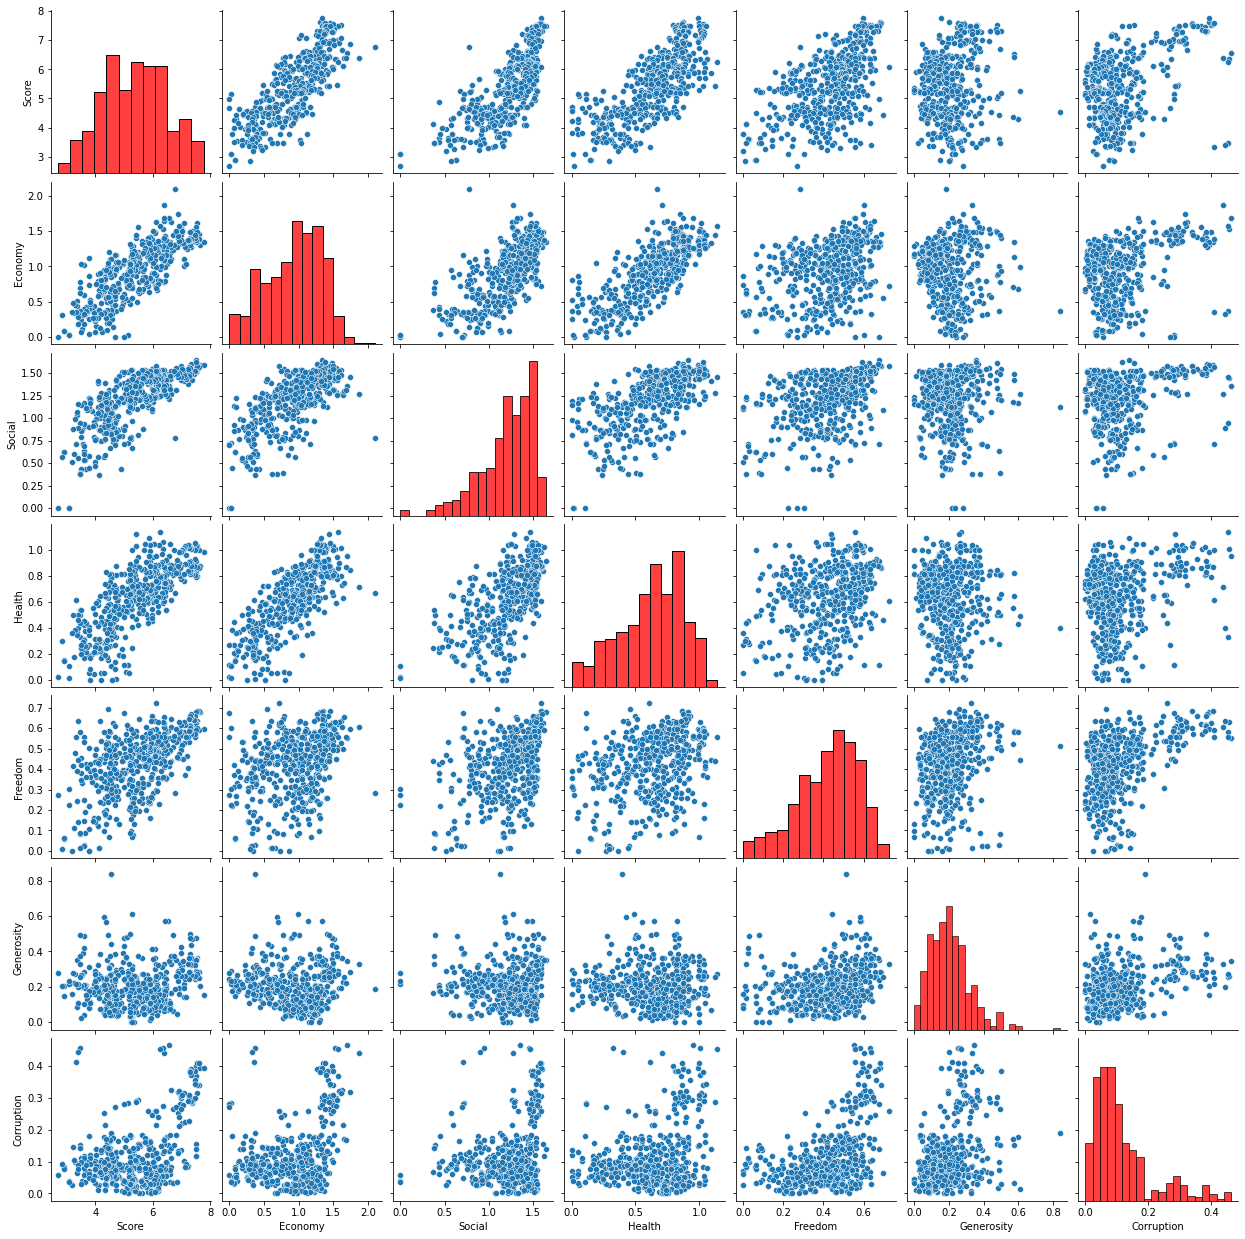

In [4]:
#fig = plt.figure(figsize=(10,5))
#sns.boxplot(all_data.Corruption)
#plt.title('TBD Title', fontsize=15)
#plt.xlabel('TBD X Label', fontsize=14)
#plt.show()

# exclude 
#df.loc[:, ~df.columns.isin(['column1', 'column2', ...])]

factor_data = all_data.loc[:, ~all_data.columns.isin(['Rank','Year'])]

sns.pairplot(factor_data, diag_kws={'color':'red'})

If we peruse the pairplots above, we can extend:

* `Score` is strongly, positively correlated with `Economy`, `Social`, and `Health`
* `Generosity` and `Corruption` appear to have a non-linear relationship with `Score`
* `Economy`, `Health`, and `Freedom` have near normal distributions
* `Social` has a left skewed distribution
* `Generosity` and `Corruption` have right skewed distributions. Both factors also appear to have outlier presence

## Correlation

Next, we'll more precisely explore multicollinearity (variables relationship with one another) in addition to the question of if there is a variable MOST correlated with a High Happiness score:

In [5]:
y, X = dmatrices('Score ~ Economy+Social+Health+Freedom+Generosity+Corruption', data=all_data, return_type='dataframe')

#create DataFrame to hold VIF values
vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 

#calculate VIF for each predictor variable 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)


     variable        VIF
0   Intercept  22.297846
1     Economy   3.385048
2      Social   2.314408
3      Health   2.750835
4     Freedom   1.520490
5  Generosity   1.175845
6  Corruption   1.447635


Multicollinearity does not appear to be a concern.

Being that we aren't training a model or anything, there's no data preprocessing required. There's no missing data, duplicates, or multicollinearity. There is outlier and non-normal variable presences but we're merely here to interpret the data. No pre-processing is required for this set and sake of this project.

In [6]:
# Visualize relationship between variables and `Score` (ie. ranked correlation)
all_data.corr().style.background_gradient(cmap="Blues")


,Rank,Score,Economy,Social,Health,Freedom,Generosity,Corruption,Year
Rank,1.000000,-0.990880,-0.803017,-0.746581,-0.747146,-0.533664,-0.095783,-0.376431,0.004535
Score,-0.990880,1.000000,0.797052,0.758071,0.750628,0.549655,0.116574,0.405518,0.019377
Economy,-0.803017,0.797052,1.000000,0.696427,0.781642,0.344916,-0.005791,0.327711,-0.080120
Social,-0.746581,0.758071,0.696427,1.000000,0.643913,0.422594,0.002014,0.208070,0.027449
Health,-0.747146,0.750628,0.781642,0.643913,1.000000,0.318608,-0.030055,0.270264,0.281177
Freedom,-0.533664,0.549655,0.344916,0.422594,0.318608,1.000000,0.264407,0.457486,-0.043303
Generosity,-0.095783,0.116574,-0.005791,0.002014,-0.030055,0.264407,1.000000,0.323686,-0.220643
Corruption,-0.376431,0.405518,0.327711,0.208070,0.270264,0.457486,0.323686,1.000000,-0.052425
Year,0.004535,0.019377,-0.080120,0.027449,0.281177,-0.043303,-0.220643,-0.052425,1.000000


The factor most correlated with `Score` is:
1. Economy
2. Social and Health
3. Freedom
4. Corruption
5. Generosity

Thus, the Economy is the leading indicator of a nation's happiness followed relatively closely by Social and Health.

A strong, happy society thus is formed by the trifecta of Wealth, Health, and Connectedness.

Now, with regard to countries trending up vs. down ...

In [30]:
# Visualize countries trending the most up vs. down
# desired output: country | 2017_rank | 2019_rank | chg  

#remove countries that do not have entries for all years
counts = all_data['Country'].value_counts()
res = all_data[all_data['Country'].isin(counts[counts == 3].index)]

#create relevant dataframes
country_list = res['Country'].unique()
ranking_df = pd.DataFrame()
ranking_df['Country'] = country_list
rank_chg = []

#calculate rank change
for country in country_list:
    country_data = res[res['Country'] == country]
    rank_19 = country_data.loc[country_data['Year'] == 2019, 'Rank'].iloc[0]
    rank_17 = country_data.loc[country_data['Year'] == 2017, 'Rank'].iloc[0]
    chg = rank_17 - rank_19
    rank_chg.append(chg)

# add rank chg column and create top 10 and bottom 10 df's 
ranking_df['Rank Chg'] = rank_chg
top_10 = ranking_df.sort_values(by=['Rank Chg'],ascending=False).head(10)
bottom_10 = ranking_df.sort_values(by=['Rank Chg']).head(10)

,Country,Rank Chg
134,Benin,41
123,Ghana,33
72,Kosovo,32
85,Honduras,32
140,Guinea,31
121,Ivory Coast,29
83,Portugal,23
89,Tajikistan,22
117,Congo (Brazzaville),21
127,Niger,21


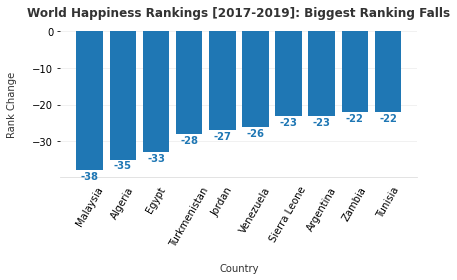

In [56]:
# Visualization for bottom 10

fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(x=bottom_10['Country'], height=bottom_10['Rank Chg'])

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False, axis='x', labelrotation = 60)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add text annotations to the top of the bars.
bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() - 2.5,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

# Add labels and a title. Note the use of `labelpad` and `pad` to add some
# extra space between the text and the tick labels.
ax.set_xlabel('Country', labelpad=15, color='#333333')
ax.set_ylabel('Rank Change', labelpad=15, color='#333333')
ax.set_title('World Happiness Rankings [2017-2019]: Biggest Ranking Falls', pad=15, color='#333333',
             weight='bold')

fig.tight_layout()


The ranking change was calculated as `Ranking 2017` - `Ranking 2019` where nations without rankings for any of the years (2017-2019) were excluded.

From above we gather the nations whose ranking declined the most from 2017 to 2019. Malaysia dropped the most, 38 spots, from 2017 to 2019.

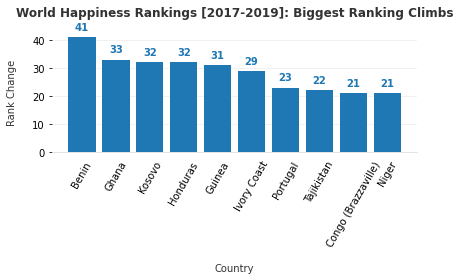

In [50]:
# Visualization for top 10

fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(x=top_10['Country'], height=top_10['Rank Chg'])

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False, axis='x', labelrotation = 60)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add text annotations to the top of the bars.
bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 2.5,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

# Add labels and a title. Note the use of `labelpad` and `pad` to add some
# extra space between the text and the tick labels.
ax.set_xlabel('Country', labelpad=15, color='#333333')
ax.set_ylabel('Rank Change', labelpad=15, color='#333333')
ax.set_title('World Happiness Rankings [2017-2019]: Biggest Ranking Climbs', pad=15, color='#333333',
             weight='bold')

fig.tight_layout()


The ranking change was calculated as `Ranking 2017` - `Ranking 2019` where nations without rankings for any of the years (2017-2019) were excluded.

From above we gather the nations whose ranking climbed the most from 2017 to 2019. Benin climbed the most, 41 spots, from 2017 to 2019.


**References**
1. [EDA outline](https://towardsdatascience.com/exploratory-data-analysis-eda-python-87178e35b14)
2. [Beautiful bar chart visualizations](https://www.pythoncharts.com/matplotlib/beautiful-bar-charts-matplotlib/)